<h1><center>Improving Credit Risk Analysis with Machine Learning: A Comparative Study</center></h1>


### Problem Statement
Credit risk models can help banks balance the risk of losses and maximise profitability. 

The study is done by performing an analysis on a dataset containing various personal and professional information of individuals, and develop a credit risk model for a bank. This model should predict the creditworthiness of a borrower based on several weighted factors.

### Results and Analysis
Data Pre-processing and Model Training
The dataset was pre-processed and split into "Train" (80%) and "Test" (20%) sets. The models employed included Logistic Regression, Decision Trees, Decision Trees with Transformed Target Regressor, Ensembled methods (Gradient Boosting, Light GBM, XGBoost), and Support Vector Machines (SVMs).

### Model Evaluation
The models were evaluated using confusion matrices, precision-recall curves, ROC AUC curves, and classification reports. Logistic Regression, Gradient Boosting, Light GBM, XGBoost, and SVMs (referred to as Group 1) had similar accuracies of around 73%, while Decision Trees and Decision Trees with Transformed Target Regressor (referred to as Group 2) had accuracies of about 61%.

### Model Selection
The Decision Tree model emerged as the best fit for credit scoring in our dataset due to its lower false positive rate and highest area under the ROC curve.

### Recommendations
The choice of the model depends on whether the bank's priority is identification accuracy or defaulter detection. For identification accuracy, Group 1 models are recommended, while for defaulter detection, the Decision Tree model is optimal.

### Conclusion and Limitations
The study concludes that different models' effectiveness can vary based on the pre-processing of data and selection of features. Logistic Regression showed the highest precision, while the Decision Tree model was best at identifying defaulters. The study also recognized several limitations and challenges, including inconsistent encoding of categorical data, ineffective outlier handling, and inconsistencies in datatypes in single columns. Further improvements could be achieved with better data selection, fine-tuning of parameters, and potentially adopting techniques like multilayer perceptron in artificial neural networks.

# CODES

## Importing Necessary Libraries

In [1]:
!pip install wandb
!pip install xgboost
!pip install lightgbm
!pip install pydotplus
!pip install missingno
import pandas as pd
import numpy as np
import seaborn as sp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, accuracy_score, roc_auc_score, auc, roc_curve as roc
from sklearn import svm
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
import xgboost
import lightgbm
import wandb
import missingno as msno

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


## Data Pre-processing and Cleaning Stage

### Import Dataset

In [2]:
df = pd.read_csv('csdata.txt',delimiter="\t",index_col=None)
type(df)

pandas.core.frame.DataFrame

In [3]:
# Preview dataset
df.head

<bound method NDFrame.head of        ID_CLIENT CLERK_TYPE  PAYMENT_DAY APPLICATION_SUBMISSION_TYPE  \
0              1          C            5                         Web   
1              2          C           15                       Carga   
2              3          C            5                         Web   
3              4          C           20                         Web   
4              5          C           10                         Web   
...          ...        ...          ...                         ...   
49995      49996          C           10                           0   
49996      49997          C           25                           0   
49997      49998          C            5                         Web   
49998      49999          C            1                         Web   
49999      50000          C           10                         Web   

       QUANT_ADDITIONAL_CARDS  POSTAL_ADDRESS_TYPE SEX  MARITAL_STATUS  \
0                           0  

In [4]:
# Preview the content of the dataset
pd.Series({col:df[col].unique() for col in df})

ID_CLIENT                         [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
CLERK_TYPE                                                                      [C]
PAYMENT_DAY                                                  [5, 15, 20, 10, 25, 1]
APPLICATION_SUBMISSION_TYPE                                         [Web, Carga, 0]
QUANT_ADDITIONAL_CARDS                                                          [0]
POSTAL_ADDRESS_TYPE                                                          [1, 2]
SEX                                                                    [F, M, N,  ]
MARITAL_STATUS                                             [6, 2, 1, 5, 3, 7, 4, 0]
QUANT_DEPENDANTS                  [1, 0, 2, 3, 4, 5, 6, 7, 10, 8, 13, 11, 9, 12,...
EDUCATION_LEVEL                                                                 [0]
STATE_OF_BIRTH                    [RN, RJ, PE, MG, BA, SP, RS, CE, PA, PB, MA,  ...
CITY_OF_BIRTH                     [Assu, rio de janeiro, GARANHUNS, CABO, RI

### Drop Useless Columns

In [5]:
# Drop all columns with all "zero" values, for example in the column FLAG_RG
df = df.loc[:, (df != 0).any(axis=0)]

In [6]:
# Drop columns with only one values
df = df.drop(columns=['CLERK_TYPE']) #only contains one value "C"
df = df.drop(columns=['FLAG_MOBILE_PHONE']) #only contains one value "N"
df = df.drop(columns=['FLAG_ACSP_RECORD']) #only contains one value "N" 

### Data Filtering

In [7]:
# Filter only applicants with age >=15 years
df = df[df['AGE']>=15]

### Handling Missing Values

In [8]:
# Create a new dataframe only to visualise the missing values
df2 = df.replace(r'^\s*$', np.nan, regex=True)

<AxesSubplot:>

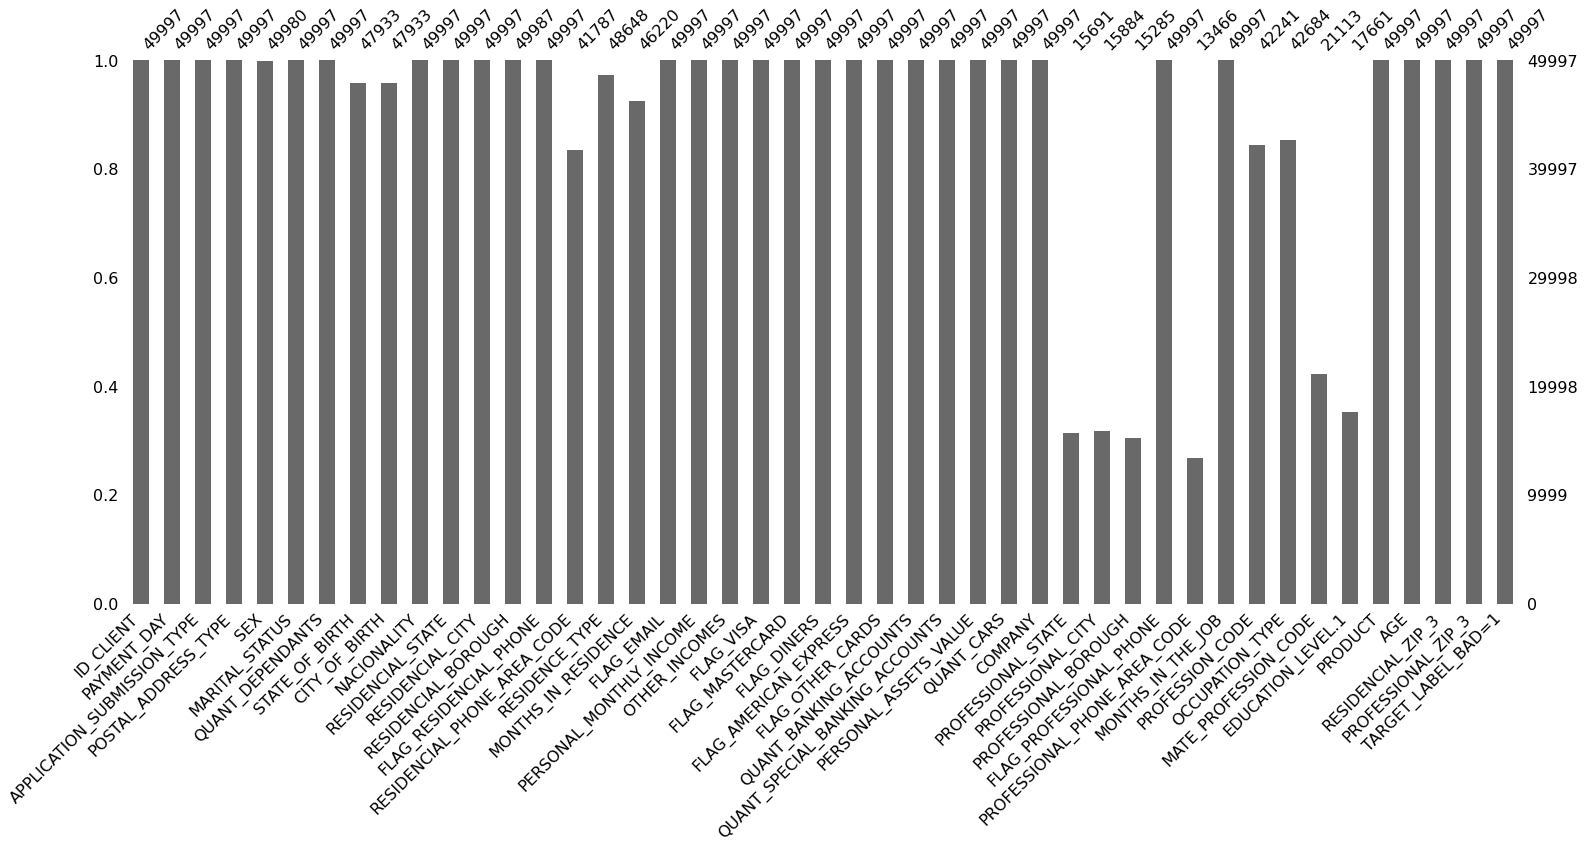

In [9]:
# Visualize missing values (1)
msno.bar(df2)

<AxesSubplot:>

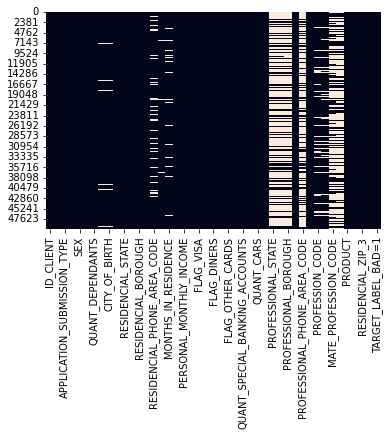

In [10]:
# Visualize missing values (2)
sp.heatmap(df2.isnull(), cbar=False)

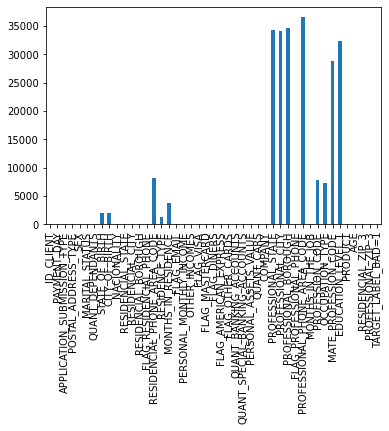

<Figure size 103680x62208 with 0 Axes>

In [11]:
# Visualize missing values (3)
df2.isnull().sum().plot.bar()
plt.figure(figsize=(1440,864))
plt.show()

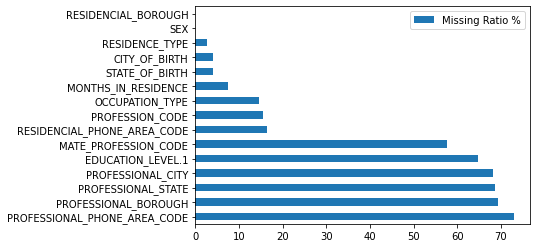

In [12]:
# Visualize missing values (4)
#Graph showing only columns having null values and their percentage of missing values
def plot_nas(df2: pd.DataFrame):
    if df2.isnull().sum().sum() != 0:
        na_df2 = (df2.isnull().sum() / len(df2)) * 100      
        na_df2 = na_df2.drop(na_df2[na_df2 == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df2})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')
plot_nas(df2)


In [13]:
# Drop columns with too many null values
df = df.drop(columns=[
    'PROFESSIONAL_CITY',
    'PROFESSIONAL_BOROUGH',
    'PROFESSIONAL_PHONE_AREA_CODE', 
    'FLAG_RESIDENCIAL_PHONE',
    'FLAG_EMAIL',
    'FLAG_VISA',
    'FLAG_MASTERCARD',
    'FLAG_DINERS',
    'FLAG_AMERICAN_EXPRESS',
    'FLAG_OTHER_CARDS',
    'FLAG_PROFESSIONAL_PHONE',
    ])

In [14]:
# Data imputation
si = SimpleImputer(missing_values=np.nan, strategy='mean') 
si.fit(df[['RESIDENCE_TYPE','MONTHS_IN_RESIDENCE','PROFESSION_CODE','OCCUPATION_TYPE']])
df[['RESIDENCE_TYPE','MONTHS_IN_RESIDENCE','PROFESSION_CODE','OCCUPATION_TYPE']] = si.transform(df[['RESIDENCE_TYPE','MONTHS_IN_RESIDENCE','PROFESSION_CODE','OCCUPATION_TYPE']])

In [15]:
# Drop records with missing values
for col in df.columns:
    df[col].replace('',np.nan,inplace=True)
    df.dropna(subset=[col],inplace=True)

df

,ID_CLIENT,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,STATE_OF_BIRTH,CITY_OF_BIRTH,NACIONALITY,...,MONTHS_IN_THE_JOB,PROFESSION_CODE,OCCUPATION_TYPE,MATE_PROFESSION_CODE,EDUCATION_LEVEL.1,PRODUCT,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD=1
5,6,10,0,1,M,2,0,MG,CARMO DO RIO CLARO,1,...,0,9.0,2.0,0.0,0.0,2,40,371,371,1
8,9,15,0,1,F,1,0,SP,LENCOIS PAULISTA,1,...,0,0.0,2.0,0.0,0.0,2,31,172,172,0
9,10,5,0,1,F,1,0,RS,SANTA MARIA,1,...,0,9.0,2.0,11.0,0.0,1,41,914,914,0
13,14,25,0,1,F,2,2,PE,CANAIBA,1,...,0,9.0,2.0,0.0,0.0,1,36,713,713,0
17,18,10,0,1,F,1,0,RJ,RIO DE JANEIRO,1,...,0,13.0,2.0,0.0,0.0,1,32,267,267,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49988,49989,15,0,1,F,2,2,SC,FLORIANOPOLIS,1,...,0,9.0,4.0,9.0,0.0,2,35,880,880,0
49989,49990,10,0,1,M,2,0,RN,SANTA CRUZ,1,...,0,11.0,5.0,11.0,0.0,1,64,596,596,0
49992,49993,10,0,1,F,2,0,CE,PIQUET CARNEIRO CE,1,...,0,9.0,5.0,0.0,0.0,1,68,603,603,0
49993,49994,1,0,1,F,2,0,BA,FLORESTA AZUL,1,...,0,2.0,3.0,0.0,4.0,1,44,440,440,1


In [16]:
df.reset_index(drop=True)

,ID_CLIENT,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,STATE_OF_BIRTH,CITY_OF_BIRTH,NACIONALITY,...,MONTHS_IN_THE_JOB,PROFESSION_CODE,OCCUPATION_TYPE,MATE_PROFESSION_CODE,EDUCATION_LEVEL.1,PRODUCT,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD=1
0,6,10,0,1,M,2,0,MG,CARMO DO RIO CLARO,1,...,0,9.0,2.0,0.0,0.0,2,40,371,371,1
1,9,15,0,1,F,1,0,SP,LENCOIS PAULISTA,1,...,0,0.0,2.0,0.0,0.0,2,31,172,172,0
2,10,5,0,1,F,1,0,RS,SANTA MARIA,1,...,0,9.0,2.0,11.0,0.0,1,41,914,914,0
3,14,25,0,1,F,2,2,PE,CANAIBA,1,...,0,9.0,2.0,0.0,0.0,1,36,713,713,0
4,18,10,0,1,F,1,0,RJ,RIO DE JANEIRO,1,...,0,13.0,2.0,0.0,0.0,1,32,267,267,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17482,49989,15,0,1,F,2,2,SC,FLORIANOPOLIS,1,...,0,9.0,4.0,9.0,0.0,2,35,880,880,0
17483,49990,10,0,1,M,2,0,RN,SANTA CRUZ,1,...,0,11.0,5.0,11.0,0.0,1,64,596,596,0
17484,49993,10,0,1,F,2,0,CE,PIQUET CARNEIRO CE,1,...,0,9.0,5.0,0.0,0.0,1,68,603,603,0
17485,49994,1,0,1,F,2,0,BA,FLORESTA AZUL,1,...,0,2.0,3.0,0.0,4.0,1,44,440,440,1


In [17]:
print('Total Columns after cleaning',len(df.columns))
df.columns

Total Columns after cleaning 34


Index(['ID_CLIENT', 'PAYMENT_DAY', 'APPLICATION_SUBMISSION_TYPE',
       'POSTAL_ADDRESS_TYPE', 'SEX', 'MARITAL_STATUS', 'QUANT_DEPENDANTS',
       'STATE_OF_BIRTH', 'CITY_OF_BIRTH', 'NACIONALITY', 'RESIDENCIAL_STATE',
       'RESIDENCIAL_CITY', 'RESIDENCIAL_BOROUGH',
       'RESIDENCIAL_PHONE_AREA_CODE', 'RESIDENCE_TYPE', 'MONTHS_IN_RESIDENCE',
       'PERSONAL_MONTHLY_INCOME', 'OTHER_INCOMES', 'QUANT_BANKING_ACCOUNTS',
       'QUANT_SPECIAL_BANKING_ACCOUNTS', 'PERSONAL_ASSETS_VALUE', 'QUANT_CARS',
       'COMPANY', 'PROFESSIONAL_STATE', 'MONTHS_IN_THE_JOB', 'PROFESSION_CODE',
       'OCCUPATION_TYPE', 'MATE_PROFESSION_CODE', 'EDUCATION_LEVEL.1',
       'PRODUCT', 'AGE', 'RESIDENCIAL_ZIP_3', 'PROFESSIONAL_ZIP_3',
       'TARGET_LABEL_BAD=1'],
      dtype='object')

## Analysis

### Model matrix stage for visually observing possible interesting data and their correlations

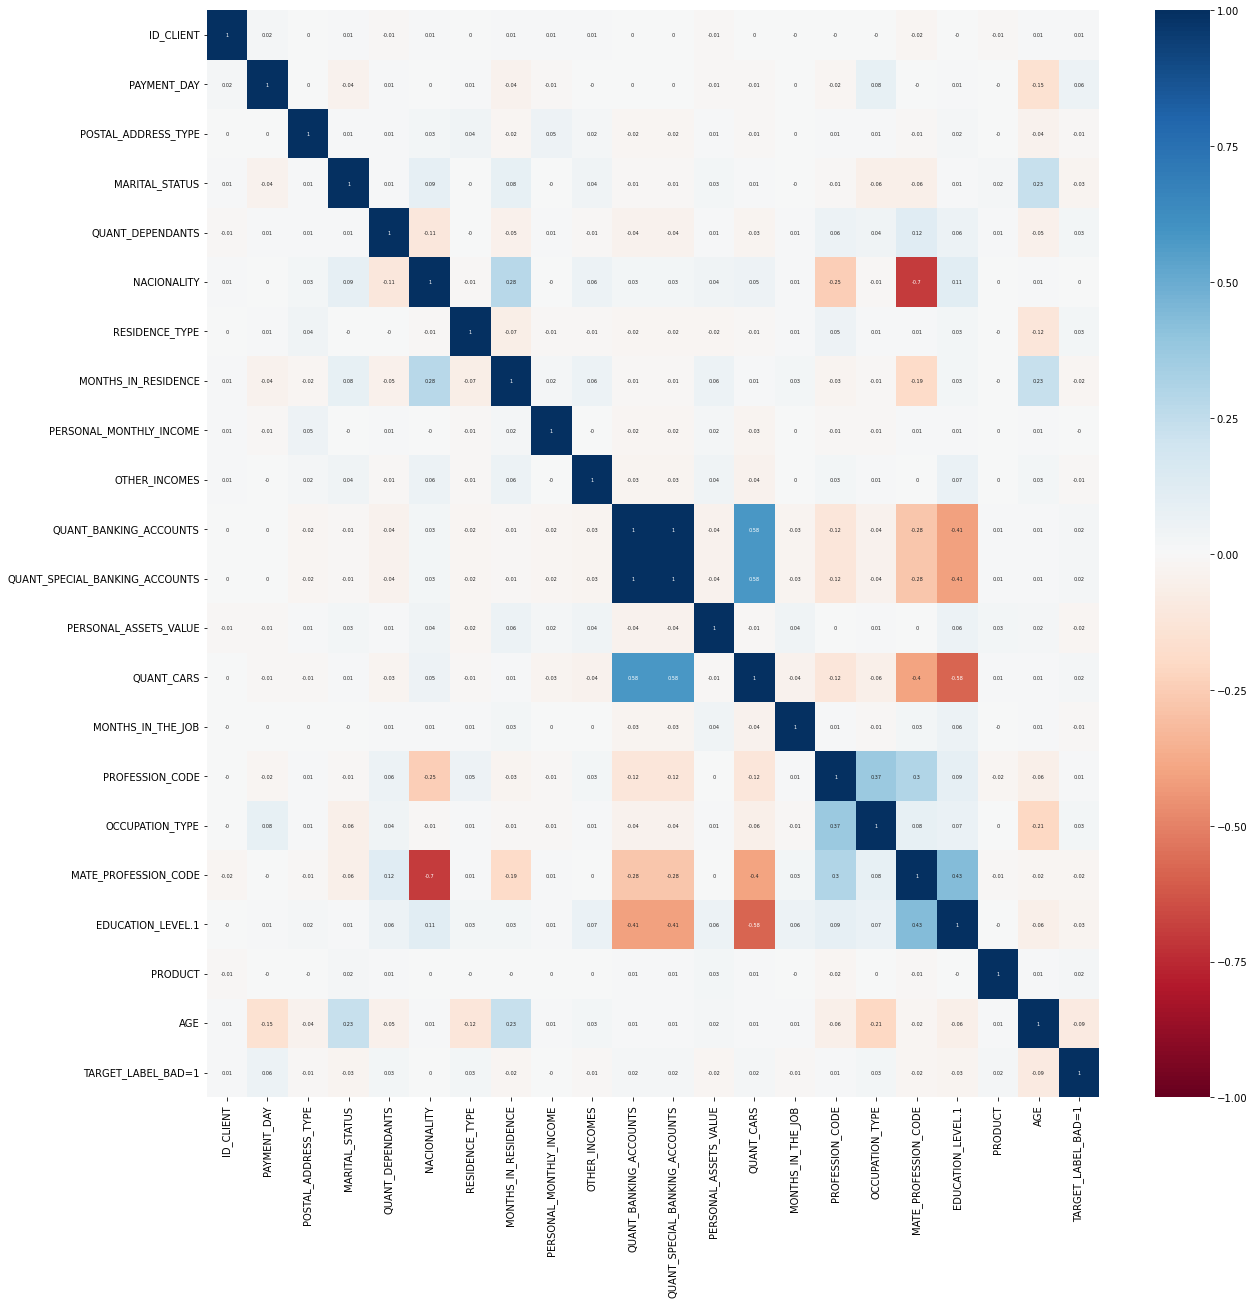

In [18]:
fig = plt.figure(figsize=(20,20))
fig.patch.set_facecolor('xkcd:white')
correlations = df.corr()
sp.heatmap( round(correlations,2),
            cmap='RdBu',
            annot=True,
            annot_kws={"size":5},
            vmin=-1,
            vmax=1)

fig.savefig(fname= 'matrix_of_corr.png')

### Creation of the train and test tests and development of the OLS model

In [19]:
ord_enc = OrdinalEncoder()
df['state_cat'] = ord_enc.fit_transform(df[['STATE_OF_BIRTH']])
df['sex_cat'] = ord_enc.fit_transform(df[['SEX']])
df['res_state_cat'] = ord_enc.fit_transform(df[['RESIDENCIAL_STATE']])
df['submit_cat'] = ord_enc.fit_transform(df[['APPLICATION_SUBMISSION_TYPE']])
df['company_cat'] = ord_enc.fit_transform(df[['COMPANY']])
df['RESIDENCIAL_ZIP_3'] = df['RESIDENCIAL_ZIP_3'].astype(float)
df['PROFESSIONAL_ZIP_3'] = df['PROFESSIONAL_ZIP_3'].astype(float)
df

,ID_CLIENT,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,STATE_OF_BIRTH,CITY_OF_BIRTH,NACIONALITY,...,PRODUCT,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD=1,state_cat,sex_cat,res_state_cat,submit_cat,company_cat
5,6,10,0,1,M,2,0,MG,CARMO DO RIO CLARO,1,...,2,40,371.0,371.0,1,11.0,2.0,10.0,0.0,1.0
8,9,15,0,1,F,1,0,SP,LENCOIS PAULISTA,1,...,2,31,172.0,172.0,0,26.0,1.0,25.0,0.0,1.0
9,10,5,0,1,F,1,0,RS,SANTA MARIA,1,...,1,41,914.0,914.0,0,23.0,1.0,22.0,0.0,1.0
13,14,25,0,1,F,2,2,PE,CANAIBA,1,...,1,36,713.0,713.0,0,16.0,1.0,25.0,0.0,1.0
17,18,10,0,1,F,1,0,RJ,RIO DE JANEIRO,1,...,1,32,267.0,267.0,0,19.0,1.0,18.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49988,49989,15,0,1,F,2,2,SC,FLORIANOPOLIS,1,...,2,35,880.0,880.0,0,24.0,1.0,23.0,0.0,0.0
49989,49990,10,0,1,M,2,0,RN,SANTA CRUZ,1,...,1,64,596.0,596.0,0,20.0,2.0,19.0,0.0,1.0
49992,49993,10,0,1,F,2,0,CE,PIQUET CARNEIRO CE,1,...,1,68,603.0,603.0,0,6.0,1.0,5.0,0.0,1.0
49993,49994,1,0,1,F,2,0,BA,FLORESTA AZUL,1,...,1,44,440.0,440.0,1,5.0,1.0,4.0,0.0,0.0


In [20]:
df.drop(columns=['SEX','STATE_OF_BIRTH','RESIDENCIAL_STATE'],inplace=True)
df.drop(columns=['CITY_OF_BIRTH'],inplace=True)
df.drop(columns=['RESIDENCIAL_PHONE_AREA_CODE'],inplace=True)
df.drop(columns=['RESIDENCIAL_CITY','RESIDENCIAL_BOROUGH'],inplace=True)
df.drop(columns=['PROFESSIONAL_STATE'],inplace=True)
df.drop(columns=['ID_CLIENT'],inplace=True)
df.drop(columns=['APPLICATION_SUBMISSION_TYPE'],inplace=True)
df.drop(columns=['COMPANY'],inplace=True)

In [21]:
y = df['TARGET_LABEL_BAD=1']
X = df.drop(['TARGET_LABEL_BAD=1'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [22]:
result = sm.OLS(y_train,sm.add_constant(X_train.astype(float))).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:     TARGET_LABEL_BAD=1   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     10.10
Date:                Mon, 05 Dec 2022   Prob (F-statistic):           4.60e-39
Time:                        01:55:42   Log-Likelihood:                -8305.8
No. Observations:               13989   AIC:                         1.666e+04
Df Residuals:                   13963   BIC:                         1.686e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

### Logistic Regression

In [23]:
sc = StandardScaler()
rfr = RandomForestRegressor()
dtr = DecisionTreeRegressor()

In [24]:
pipe = make_pipeline(sc,LogisticRegression())
pipe.fit(X_train,y_train)
Pipeline(steps=[('standardscaler',sc),('logisticregression',LogisticRegression())])
pipe.score(X_test,y_test)
y_pipe_pred = pipe.predict(X_test)
print(roc_auc_score(y_test,y_pipe_pred))

0.5003435848723771


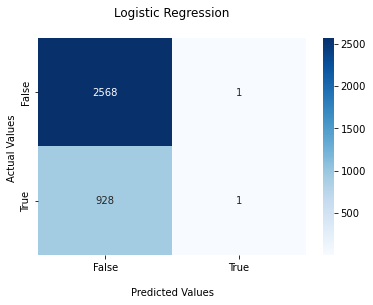

In [25]:
# Create confusion matrix
cf_matrix1 =confusion_matrix(y_test,y_pipe_pred)
ax = sp.heatmap(cf_matrix1, annot=True, fmt='g', cmap='Blues')
ax.set_title('Logistic Regression\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

In [26]:
ttr = TransformedTargetRegressor(regressor=rfr, transformer=QuantileTransformer(output_distribution='normal'))
ttr.fit(X_train,y_train)
y_pred_ttr = ttr.predict(X_test)
print(roc_auc_score(y_test,y_pred_ttr))

0.5058072128520854


### Decision Trees

In [27]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train,y_train)

y_pred = tree_clf.predict(X_test)

print(roc_auc_score(y_test,y_pred))
print(tree_clf.tree_.node_count)
print(classification_report(y_test,y_pred))

0.5235519049895646
6577
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      2569
           1       0.30      0.32      0.31       929

    accuracy                           0.62      3498
   macro avg       0.52      0.52      0.52      3498
weighted avg       0.63      0.62      0.62      3498



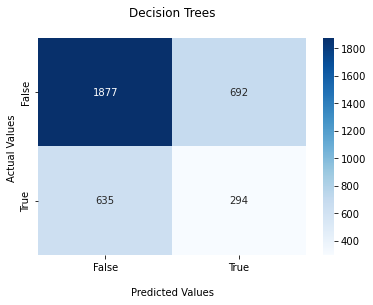

In [28]:
cf_matrix2=confusion_matrix(y_test,y_pred)
ax = sp.heatmap(cf_matrix2, annot=True, fmt='g', cmap='Blues')
ax.set_title('Decision Trees\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

### Decision Tree with Transformed Target Regressor

In [29]:
regr_trans = TransformedTargetRegressor(regressor=dtr,transformer=QuantileTransformer(output_distribution='normal'))
regr_trans.fit(X_train,y_train)
y_dtr_pred = regr_trans.predict(X_test)
print(roc_auc_score(y_test,y_dtr_pred))
print(classification_report(y_test,y_dtr_pred))

0.5138303386280322
              precision    recall  f1-score   support

           0       0.74      0.73      0.73      2569
           1       0.28      0.30      0.29       929

    accuracy                           0.61      3498
   macro avg       0.51      0.51      0.51      3498
weighted avg       0.62      0.61      0.62      3498



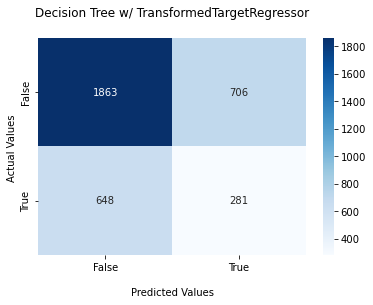

In [30]:
cf_matrix3 = confusion_matrix(y_test,y_dtr_pred)
ax = sp.heatmap(cf_matrix3, annot=True, fmt='g', cmap='Blues')
ax.set_title('Decision Tree w/ TransformedTargetRegressor\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

### Ensembled Boosting Techniques (Gradient Boosting, LGBM, XGBoost)

In [31]:
def boosting(x):
    regr_trans_2 = TransformedTargetRegressor(regressor=x,transformer=QuantileTransformer(output_distribution='normal'))
    regr_trans_2.fit(X_train.astype(int),y_train)
    y_pred_boost = regr_trans_2.predict(X_test)
    algorithm_name = x.__class__.__name__
    return algorithm_name,roc_auc_score(y_test,y_pred_boost),y_pred_boost

In [32]:
algorithm = [GradientBoostingRegressor(),lightgbm.LGBMRegressor(),xgboost.XGBRFRegressor()]
scores = []
classification_scores = []
roc_curve = []
precision_recall = []
confusion_m = []


for i in algorithm:
    scores.append(boosting(i))
    a,b,c = boosting(i)
    classification_scores.append(classification_report(y_test,c))
    roc_curve.append(roc(y_test,c))
    precision_recall.append(precision_recall_curve(y_test,c))
    confusion_m.append(confusion_matrix(y_test,c))
    print(classification_report(y_test,c)) 

print(scores)


              precision    recall  f1-score   support

           0       0.73      1.00      0.85      2569
           1       0.38      0.00      0.01       929

    accuracy                           0.73      3498
   macro avg       0.55      0.50      0.43      3498
weighted avg       0.64      0.73      0.62      3498

              precision    recall  f1-score   support

           0       0.74      0.99      0.84      2569
           1       0.37      0.01      0.03       929

    accuracy                           0.73      3498
   macro avg       0.55      0.50      0.44      3498
weighted avg       0.64      0.73      0.63      3498

              precision    recall  f1-score   support

           0       0.73      1.00      0.85      2569
           1       0.27      0.00      0.01       929

    accuracy                           0.73      3498
   macro avg       0.50      0.50      0.43      3498
weighted avg       0.61      0.73      0.62      3498

[('GradientBoosting

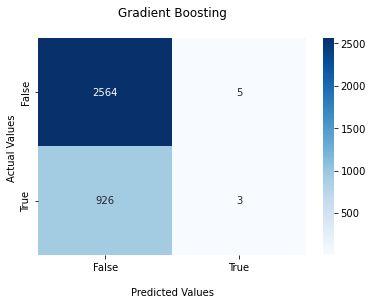

In [33]:
#Visualise confusion matrix
ax = sp.heatmap(confusion_m[0], annot=True, fmt='g', cmap='Blues')
ax.set_title('Gradient Boosting\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

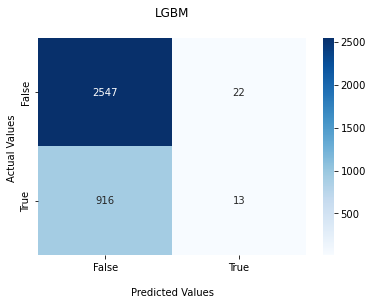

In [34]:
#Visualise confusion matrix
ax = sp.heatmap(confusion_m[1], annot=True, fmt='g', cmap='Blues')
ax.set_title('LGBM\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

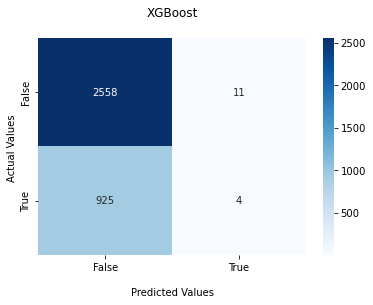

In [35]:
#Visualise confusion matrix
ax = sp.heatmap(confusion_m[2], annot=True, fmt='g', cmap='Blues')
ax.set_title('XGBoost\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

### Support Vector Machines (SVMs)

In [36]:
clf = svm.SVC(kernel='linear',C=1).fit(sc.fit_transform(X_train),y_train)
y_pred_svm = clf.predict(sc.fit_transform(X_test))
#clf.fit(X_train,y_train)
#clf.score(X_test,y_test)
print("Accuracy:", roc_auc_score(y_test,y_pred_svm))
print(classification_report(y_test,y_pred_svm))

Accuracy: 0.5
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      2569
           1       0.00      0.00      0.00       929

    accuracy                           0.73      3498
   macro avg       0.37      0.50      0.42      3498
weighted avg       0.54      0.73      0.62      3498



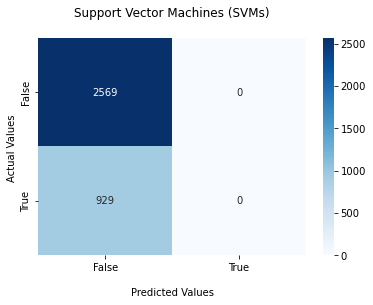

In [37]:
cf_matrix4 = confusion_matrix(y_test,y_pred_svm)
ax = sp.heatmap(cf_matrix4, annot=True, fmt='g', cmap='Blues')
ax.set_title('Support Vector Machines (SVMs)\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

## Result Visualisation

### Decision Trees

Accuracy: 0.7344196683819325
AUC: 0.5
Number of nodes: 15


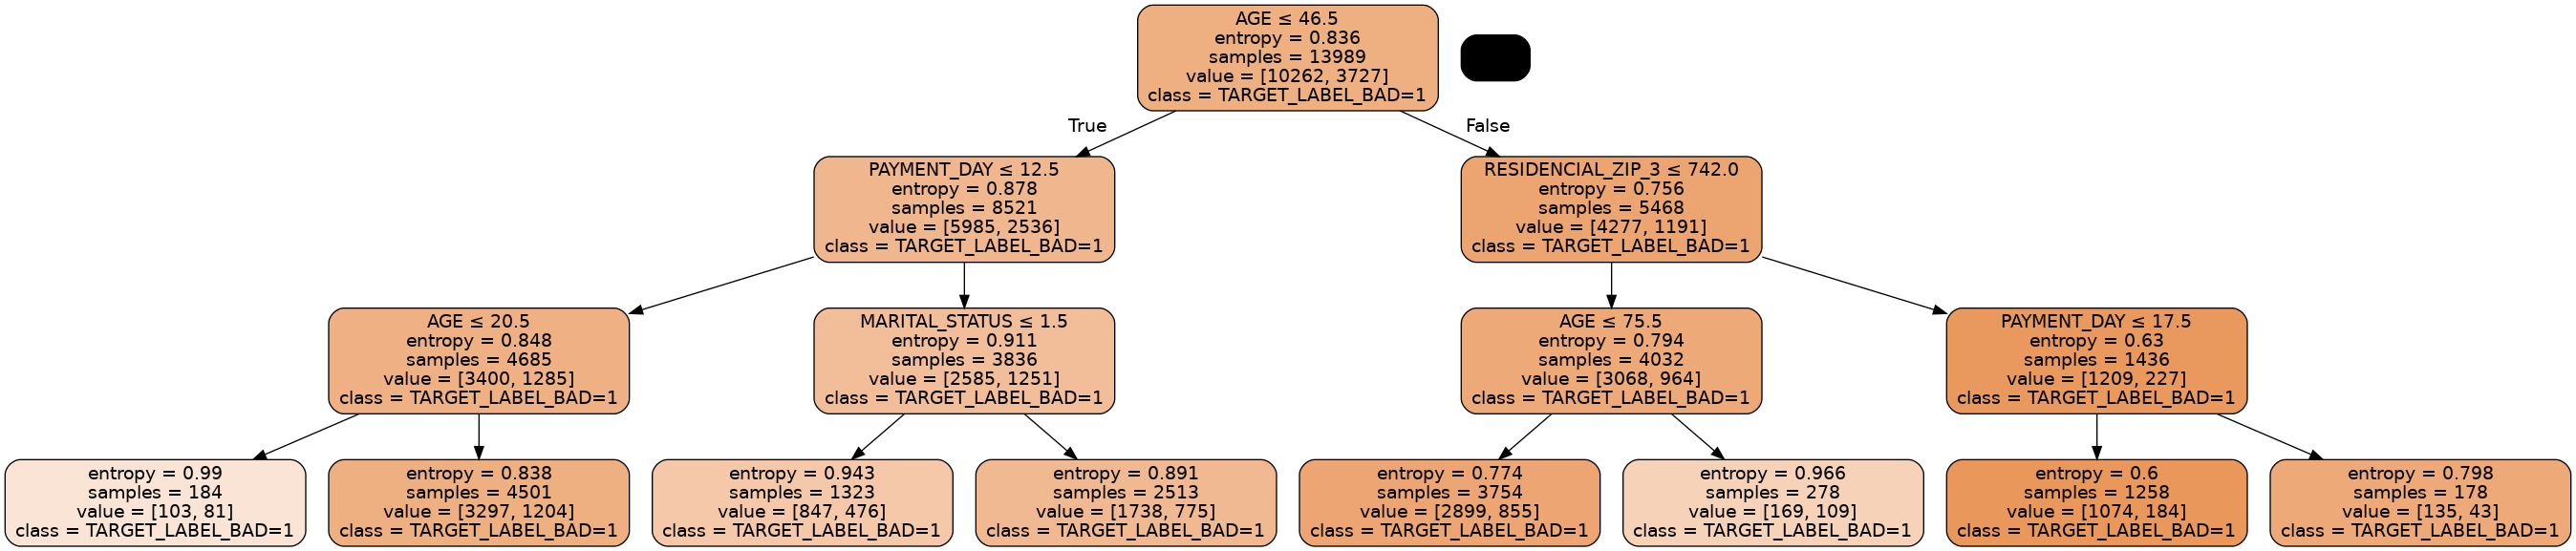

In [38]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
decision_tree2 = DecisionTreeClassifier(max_depth=3,min_samples_leaf=10,criterion='entropy')
decision_tree2.fit(X_train,y_train)
prediction = decision_tree2.predict(X_test)

print('Accuracy:', accuracy_score(y_test,prediction))
print('AUC:',roc_auc_score(y_test,prediction))
print('Number of nodes:', decision_tree2.tree_.node_count)
dot_data = StringIO()

export_graphviz(decision_tree2, out_file=dot_data,  
                filled=True, rounded=True,class_names=['TARGET_LABEL_BAD=1'],
                special_characters=True,feature_names=X.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### ROC

In [39]:
# Calculate False Positive Rate (FPR) and True Positive Rate (TPR) for all models

fpr_lr, tpr_lr, thresholds_lr = roc(y_test,y_pipe_pred) # logistic regression
fpr_dt, tpr_dt, thresholds_dt = roc(y_test,y_pred) # decision trees
fpr_dtbm, tpr_dtbm, thresholds_dtbm = roc(y_test,y_dtr_pred) # decision trees boosting method
fpr_gb, tpr_gb, thresholds_gb = (roc_curve[0]) # ensembled - gradient boosting
fpr_lgbm, tpr_lgbm, thresholds_lgbm = (roc_curve[1]) # ensembled - lgbm
fpr_xgb, tpr_xgb, thresholds_xgb = (roc_curve[2]) # ensembled - xgb
fpr_svm, tpr_svm, thresholds_svm = roc(y_test,y_pred_svm) # support vector machines

In [40]:
# Calculate ROC and AUC for all models

roc_auc_lr = auc(fpr_lr,tpr_lr) # logistic regression
roc_auc_dt = auc(fpr_dt,tpr_dt) # decision trees
roc_auc_dtbm = auc(fpr_dtbm,tpr_dtbm) # decision trees w/ TransformedTargetRegressor
roc_auc_gb = auc(fpr_gb,tpr_gb) # ensembled - gradient boosting
roc_auc_lgbm = auc(fpr_lgbm,tpr_lgbm) # ensembled - lgbm
roc_auc_xgb = auc(fpr_xgb,tpr_xgb) # ensembled - xgb
roc_auc_svm = auc(fpr_svm,tpr_svm) # support vector machines

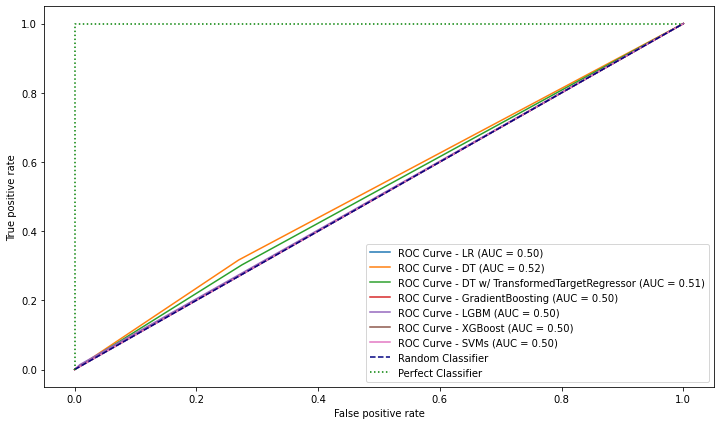

In [41]:
# Visualize the ROC

plt.figure(figsize=(12, 7))
plt.plot(fpr_lr, tpr_lr, label='ROC Curve - LR (AUC = %0.2f)' % (roc_auc_lr))
plt.plot(fpr_dt, tpr_dt, label='ROC Curve - DT (AUC = %0.2f)' % (roc_auc_dt))
plt.plot(fpr_dtbm, tpr_dtbm, label='ROC Curve - DT w/ TransformedTargetRegressor (AUC = %0.2f)' % (roc_auc_dtbm))
plt.plot(fpr_gb, tpr_gb, label='ROC Curve - GradientBoosting (AUC = %0.2f)' % (roc_auc_gb))
plt.plot(fpr_lgbm, tpr_lgbm, label='ROC Curve - LGBM (AUC = %0.2f)' % (roc_auc_lgbm))
plt.plot(fpr_xgb, tpr_xgb, label='ROC Curve - XGBoost (AUC = %0.2f)' % (roc_auc_xgb))
plt.plot(fpr_svm, tpr_svm, label='ROC Curve - SVMs (AUC = %0.2f)' % (roc_auc_svm))
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()

### Precision vs. Recall

Precision = True Positives / (True Positives + False Positives) | Recall = True Positives / (True Positives + False Negatives) | Recall == Sensitivity

In [42]:
baseline_model = sum(y_test == 1) / len(y_test)

#logistic regression
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pipe_pred)
auc_lr = auc(recall_lr, precision_lr)

#decision trees
precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_pred)
auc_dt = auc(recall_dt, precision_dt)

#decision trees boosting model
precision_dtbm, recall_dtbm, _ = precision_recall_curve(y_test, y_dtr_pred)
auc_dtbm = auc(recall_dtbm, precision_dtbm)

#ensembled - gradient boosting
precision_gb, recall_gb, _ = precision_recall_curve(y_test, y_dtr_pred)
auc_gb = auc(recall_gb, precision_gb)

#ensembled - LGBM
precision_lgbm, recall_lgbm, _ = precision_recall[0]
auc_lgbm = auc(recall_lgbm, precision_lgbm)

#ensembled - XGBoost
precision_xgb, recall_xgb, _ = precision_recall[1]
auc_xgb = auc(recall_xgb, precision_xgb)

#support vector machines (svm)
precision_svm, recall_svm, _ = precision_recall[2]
auc_svm = auc(recall_svm, precision_svm)

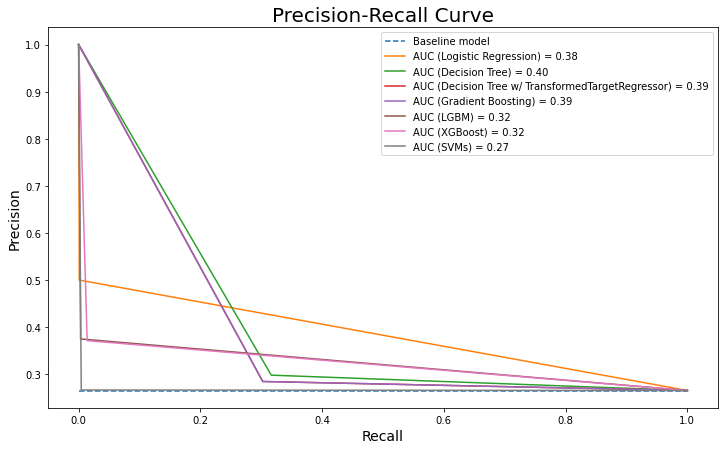

In [43]:
plt.figure(figsize=(12, 7))
plt.plot([0, 1], [baseline_model, baseline_model], linestyle='--', label='Baseline model')
plt.plot(recall_lr, precision_lr, label=f'AUC (Logistic Regression) = {auc_lr:.2f}')
plt.plot(recall_dt, precision_dt, label=f'AUC (Decision Tree) = {auc_dt:.2f}')
plt.plot(recall_dtbm, precision_dtbm, label=f'AUC (Decision Tree w/ TransformedTargetRegressor) = {auc_dtbm:.2f}')
plt.plot(recall_gb, precision_gb, label=f'AUC (Gradient Boosting) = {auc_gb:.2f}')
plt.plot(recall_lgbm, precision_lgbm, label=f'AUC (LGBM) = {auc_lgbm:.2f}')
plt.plot(recall_xgb, precision_xgb, label=f'AUC (XGBoost) = {auc_xgb:.2f}')
plt.plot(recall_svm, precision_svm, label=f'AUC (SVMs) = {auc_svm:.2f}')
plt.title('Precision-Recall Curve', size=20)
plt.xlabel('Recall', size=14)
plt.ylabel('Precision', size=14)
plt.legend();

### Classification Report of All Models

In [44]:
print("### FOR LOGISTIC REGRESSION")
print(classification_report(y_test,y_pipe_pred))
print("### FOR DECISION TREE")
print(classification_report(y_test,y_pred))
print("### FOR DECISION TREE WITH TransformedTargetRegressor")
print(classification_report(y_test,y_dtr_pred))
print(f"### FOR ENSEMBLED {scores[0][0]}".upper())
print(classification_scores[0])
print(f"### FOR ENSEMBLED {scores[1][0]}".upper())
print(classification_scores[1])
print(f"### FOR ENSEMBLED {scores[2][0]}".upper())
print(classification_scores[2])
print("### FOR SUPPORT VECTOR MACHINE")
print(classification_report(y_test,y_pred_svm))

### FOR LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      2569
           1       0.50      0.00      0.00       929

    accuracy                           0.73      3498
   macro avg       0.62      0.50      0.42      3498
weighted avg       0.67      0.73      0.62      3498

### FOR DECISION TREE
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      2569
           1       0.30      0.32      0.31       929

    accuracy                           0.62      3498
   macro avg       0.52      0.52      0.52      3498
weighted avg       0.63      0.62      0.62      3498

### FOR DECISION TREE WITH TransformedTargetRegressor
              precision    recall  f1-score   support

           0       0.74      0.73      0.73      2569
           1       0.28      0.30      0.29       929

    accuracy                           0.61      3498
   macro avg       0.51 